In [1]:
### This script carries out a fitting of the various Glazer tilt systems to measured data on a perovskite. 
### It takes in a 2x2x2 40-atom supercell of the perovskite with P1 symmetry.

# Script for fitting multiple Glazersystems to a structure, including A cation symmetry

In [1]:
# Import packages that we will need.
import os
import sys
import collections
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from diffpy.srfit.fitbase import FitContribution, FitRecipe, FitResults, Profile, FitHook
from diffpy.srfit.pdf import PDFParser, PDFGenerator
from diffpy.structure import Structure
from scipy.optimize import least_squares

from sympy import *
%matplotlib inline

In [56]:
# GLAZERSYSTEM = 23
"""
# Group A: High symmetry tilt systems

a0a0a0 ID: 23
a-a-a- ID: 14
a0a0c- ID :22
a0a0c+ ID :21
a0b-b- ID :20
a-b+a- ID :10

# Group B: Multiple A-site tilt systems
a+a+a+ ID :3
a0b-c+ ID :17
a0b+b+ ID :16
a+a+c- ID :5

# Group C: transitional/low symmetry tilt systems
a-a-c- ID :13
a0b-c- ID :19
a-b-c- ID :12
a+b-c- ID :8
a+b+c+ ID :1
"""

###### Defining the Glazer modes
# Non-zero amplitudes indicating active mode. 

mode_values = {23: {'alpha': 0, 'beta': 0, 'gamma': 0}, 22: {'alpha': 0, 'beta': 0, 'gamma': -15}, 
               21: {'alpha': 0, 'beta': 0, 'gamma': 15}, 20: {'alpha': 0, 'beta': -15, 'gamma': -15}, 
               19: {'alpha': 0, 'beta': -15, 'gamma': -14}, 18: {'alpha': 0, 'beta': 15, 'gamma': -15}, 
               17: {'alpha': 0, 'beta': 15, 'gamma': -14}, 16: {'alpha': 0, 'beta': 15, 'gamma': 15}, 
               15: {'alpha': 0, 'beta': 15, 'gamma': 14}, 14: {'alpha': -15, 'beta': -15, 'gamma': -15}, 
               13: {'alpha': -15, 'beta': -14, 'gamma': -14}, 12: {'alpha': -13, 'beta': -14, 'gamma': -15},
               11: {'alpha': 15, 'beta': -15, 'gamma': -15}, 10: {'alpha': 6, 'beta': -9.5, 'gamma': -9.5}, 
               9: {'alpha': 15, 'beta': -15, 'gamma': -14}, 8: {'alpha': 16, 'beta': -15, 'gamma': -14}, 
               7: {'alpha': 15, 'beta': 15, 'gamma': -15}, 6: {'alpha': 15, 'beta': 14, 'gamma': -14},
               5: {'alpha': 15, 'beta': 15, 'gamma': -14}, 4: {'alpha': 15, 'beta': 14, 'gamma': -16}, 
               3: {'alpha': 15, 'beta': 15, 'gamma': 15}, 2: {'alpha': 15, 'beta': 14, 'gamma': 14}, 
               1: {'alpha': 13, 'beta': 14, 'gamma': 15}}

mode_spacegroups = {23: 'Pm-3m', 22: 'I4/m', 21: 'P4/mnc', 20: 'I2/m', 19: 'I-1', 
                    18: 'C2/c', 17: 'C2/c', 16: 'P4_2/nnm', 15: 'Pnnn', 14: 'R-3', 
                    13: 'F-1', 12: 'F-1', 11: 'P2_1/c', 10: 'P1', 9: 'P-1', 
                    8: 'P-1', 7: 'P4_2/n', 6: 'P2/c', 5: 'P4_2/n', 4: 'P2/c', 
                    3: 'Pn-3', 2: 'Pnnn', 1: 'Pnnn'}

#constraints for tiltsystems (currently only y and z for system 10)
#A_constraints = {10: [['0.25+Aydisp1', '0.25+Azdisp1'], 
#                      ['0.25+Aydisp2', '0.75+Azdisp2'], 
#                      ['0.75+Aydisp2', '0.25+Azdisp2'], 
#                      ['0.75+Aydisp1', '0.75+Azdisp1'], 
#                      ['0.25-Aydisp1', '0.25-Azdisp1'], 
#                      ['0.25-Aydisp2', '0.75-Azdisp2'], 
#                      ['0.75-Aydisp2', '0.25-Azdisp2'], 
#                      ['0.75-Aydisp1', '0.75-Azdisp1']]}
A_constraints = {10: [['0.25+Aydisp1', '0.25+Azdisp1'], 
                      ['0.25-Aydisp1', '0.75+Azdisp1'], 
                      ['0.75-Aydisp1', '0.25+Azdisp1'], 
                      ['0.75+Aydisp1', '0.75+Azdisp1'], 
                      ['0.25-Aydisp1', '0.25-Azdisp1'], 
                      ['0.25+Aydisp1', '0.75-Azdisp1'], 
                      ['0.75+Aydisp1', '0.25-Azdisp1'], 
                      ['0.75-Aydisp1', '0.75-Azdisp1']]}

A_constraints = {10: 
[['0.25+Aydisp1', '0.25+Azdisp1'], 
 ['0.25+Aydisp2', '0.75+Azdisp2'], 
 ['0.75+Aydisp2', '0.25+Azdisp2'], 
 ['0.75+Aydisp1', '0.75+Azdisp1'], 
 ['0.25-Aydisp1', '0.25-Azdisp1'], 
 ['0.25-Aydisp2', '0.75-Azdisp2'], 
 ['0.75-Aydisp2', '0.25-Azdisp2'], 
 ['0.75-Aydisp1', '0.75-Azdisp1']]}



In [39]:
###### Defining rotation patterns for the six possible dimensions of Glazer tilts:

rotation_pattern = {

'alpha': {'IP': {'clockwise': [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0], [0.5, 0.5, 0.5]],
                 'anti-clockwise': [[0, 0, 0.5], [0, 0.5, 0], [0.5, 0, 0.5], [0.5, 0.5, 0]]},
         'OOP': {'clockwise': [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]], 
                 'anti-clockwise': [[0, 0, 0.5], [0, 0.5, 0], [0.5, 0, 0], [0.5, 0.5, 0.5]]}},

'beta': {'IP': {'clockwise': [[0, 0, 0], [0.5, 0, 0.5], [0, 0.5, 0], [0.5, 0.5, 0.5]], 
                'anti-clockwise': [[0.5, 0, 0], [0.5, 0.5, 0], [0, 0, 0.5], [0, 0.5, 0.5]]}, 
        'OOP': {'clockwise': [[0, 0, 0], [0.5, 0, 0.5], [0.5, 0.5, 0], [0, 0.5, 0.5]], 
                'anti-clockwise': [[0.5, 0, 0], [0, 0, 0.5], [0, 0.5, 0], [0.5, 0.5, 0.5]]}},

'gamma': {'IP': {'clockwise': [[0, 0, 0], [0.5, 0.5, 0], [0, 0, 0.5], [0.5, 0.5, 0.5]], 
                 'anti-clockwise': [[0.5, 0, 0], [0, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]]}, 
         'OOP': {'clockwise': [[0, 0, 0], [0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]], 
                 'anti-clockwise': [[0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5], [0.5, 0.5, 0.5]]}}
    
}


In [40]:
# Rotation function
def rotate_octahedron(octahedron, GLAZERSYSTEM):
    # Function that takes in the positions of the three oxygens and its pivot 
    # atom (octahedron) and the Glazer mode ID and creates a symbolic expression 
    # for the new position
    print("Creating variables for octahedron {}".format(octahedron[0]))
    amp = {}
    pattern_indicator = {}
    sign = {}
    Xs_disp = {}
    axes = np.array([[1,0,0], [0,1,0], [0,0,1]])
    
    # Fetch position for pivot atom (B)
    B = octahedron[0]
    # Fetch cubic oxygen positions
    Xs = octahedron[1:4]
    Xs_rel = Xs - B
    
    # define active variables
    variables = [Symbol('alpha_var'), Symbol('beta_var'), Symbol('gamma_var')]
    amps = mode_values[GLAZERSYSTEM]['alpha'], mode_values[GLAZERSYSTEM]['beta'], mode_values[GLAZERSYSTEM]['gamma']
    #print(variables[1])
    #print(amps[1])
    
    for i in [1,2]:
        if abs(amps[i]) == abs(amps[i-1]):
            variables[i] = variables[i-1]
    #print('The effective variables for the system are: {}'.format(variables))
    
    # Go through all the Glazer amplitudes, alpha, beta and gamma and fetch relevant rotation pattern
    i = 0
    for key in mode_values[GLAZERSYSTEM].keys():
        amp[key] = np.abs(np.float(mode_values[GLAZERSYSTEM][key]))
        pattern_indicator[key] = np.sign(mode_values[GLAZERSYSTEM][key])
        if amp[key] > 0:
            if pattern_indicator[key] > 0:
                typ = 'IP'
            if pattern_indicator[key] < 0:
                typ = 'OOP'
                
            # set sign of rotation for the current octahedron
            if list(B) in rotation_pattern[key][typ]['clockwise']:
                sign[key] = +1
            if list(B) in rotation_pattern[key][typ]['anti-clockwise']:
                sign[key] = -1
            
        if amp[key] == 0:
            sign[key] = 0
        
        # Create distortion around current axis
        R = axes[i]
        Xs_disp[key] = symarray('', len(Xs))
        for j in range(len(Xs_rel)):
            x = Xs_rel[j]
            disp_dir = Matrix(np.nan_to_num(np.cross(R, x) / np.linalg.norm(np.cross(R, x))))
            x_scaled = Matrix(x).multiply(cos(variables[i]/180*pi)) # length of vector*cosine
            x_scaled_len = sqrt((x_scaled[0])**2 + (x_scaled[1])**2 + (x_scaled[2])**2)
            disp_amp = x_scaled_len * tan(sign[key]*variables[i]/180*pi)
            x_disp = disp_dir * disp_amp
            Xs_disp[key][j] = x_disp
    
        i = i+1
    
    Xs_disp_all = Xs_disp['alpha'] + Xs_disp['beta'] + Xs_disp['gamma'] # all relative displacements
    
    Xs_new = symarray('', len(Xs))
    for i in range(len(Xs)):
        Xs_new[i] = Xs_disp_all[i] + Matrix(Xs[i])
    
    return Xs_new, variables

In [41]:
def lattice_parameters_constraints(octahedron_disp, a_par, nx, ny, nz):

    #Takes in any displaced octahedron and assesses the scaling of the lattice parameters
    B = octahedron_disp[0]
    X1 = octahedron_disp[1]
    X2 = octahedron_disp[2]
    X3 = octahedron_disp[3]
    O1x, O1y, O1z = X1 - B
    O2x, O2y, O2z = X2 - B
    O3x, O3y, O3z = X3 - B
 
    a_num = 1 - 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) - 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    a_den = 1 - 16*O1y**2 + 16*(-1+16*O3y**2)*O1z**2 + 256*(O1y**2-O3y**2)*O2z**2
    scale_a = sqrt(a_num/a_den)

    b_num = 1 - 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) - 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    b_den = 1 + 16*O2x**2 *(-1 + 16*O1z**2) - 16*O2z**2 + 256*O3x**2 *(-O1z**2 + O2z**2)
    scale_b = sqrt(b_num/b_den)

    c_num = -1 + 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) + 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    c_den = -1 + O3x**2 *(16-256*O1y**2) + 256*O2x**2 *(O1y**2 - O3y**2) + 16*O3y**2
    scale_c = sqrt(c_num/c_den)
    
    a = Symbol(a_par)
    a_new = a*nx/scale_a
    b_new = a*ny/scale_b
    c_new = a*nz/scale_c
    
    return a_new, b_new, c_new

In [42]:
#test
octa = np.array([[0.0, 0.5, 0.0],
                [0.25, 0.5, 0.0],
                [0.0, 0.75, 0.],
                [0.0, 0.5, 0.25]])
GM = 10
#rotate_octahedron(octa, GM)
Xs_newt, variables_active = rotate_octahedron(octa, GM)
octa_disp = Matrix(octa[0]), Xs_newt[0], Xs_newt[1], Xs_newt[2]
#a_newt, b_newt, c_newt = lattice_parameters_constraints(octa_disp, 'a_cubic', 2, 2, 2)
print(Xs_newt)

Creating variables for octahedron [0.  0.5 0. ]
[Matrix([
[                                                          0.25],
[-0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180) + 0.5],
[       0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180)]])
 Matrix([
[   0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180)],
[                                                      0.75],
[-0.25*sqrt(cos(pi*alpha_var/180)**2)*tan(pi*alpha_var/180)]])
 Matrix([
[       -0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180)],
[0.25*sqrt(cos(pi*alpha_var/180)**2)*tan(pi*alpha_var/180) + 0.5],
[                                                           0.25]])]


/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


In [43]:
def plotresults(recipe, resfithook, figname):
    """
    Creates plots of the fitted PDF and residual, displays them, and
    then writes them to disk as *.pdf files.

    Parameters
    ----------
    recipe :    The optimized Fit Recipe object containing the PDF data
                we wish to plot
    figname :   string, the location and name of the figure file to create

    Returns
    ----------
    None
    """
    r = recipe.crystal.profile.x

    g = recipe.crystal.profile.y
    gcalc = recipe.crystal.profile.ycalc
    diffzero = -0.65 * max(g) * np.ones_like(g)
    diff = g - gcalc + diffzero

    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.style.use(os.path.join(os.pardir,
                               "utils",
                               "billinge.mplstyle"))

    fig, ax = plt.subplots(2, 1)

    ax[0].plot(r, g, ls="None",
             marker="o", ms=3, mew=0.2,
             mfc="None", label="$G(r)$ Data")
    ax[0].plot(r, gcalc, lw=1.3, label="$G(r)$ Fit")
    ax[0].plot(r, diff, lw=1.2, label="$G(r)$ diff")
    ax[0].plot(r, diffzero, lw=1.0, ls="--", c="black")
    ax[0].set_xlabel("$r$ [$\mathrm{\AA}]$")
    ax[0].set_ylabel("$G$ [$\mathrm{\AA}$$^{-2}$]")
    ax[0].tick_params(axis="both",
                    which="major",
                    top=True,
                    right=True)
    ax[0].set_xlim(PDF_RMIN, PDF_RMAX)
    ax[0].legend()
    

    ax[1].plot(resfithook.rws, lw=1.0, marker='o', c="black")
    ax[1].set_xlabel("steps")
    ax[1].set_ylabel("rw")
    ax[1].tick_params(axis="both",
                    which="major",
                    top=True,
                    right=True)

    plt.tight_layout()
    plt.show()
    fig.savefig(figname + ".pdf", format="pdf")

    # End of function

In [57]:
######## Functions that will carry out the refinement ##################
# Make the recipe that the fit will follow.
# This Fit recipe object contains the PDF data, information on all the
# structures and all relevant details necessary to run the fit.
def makerecipe(stru1, datname):
    """
    Creates and returns a Fit Recipe object

    Parameters
    ----------
    stru1 :     diffpy structure object, contains the structure used to fit
                the PDF data
    datname :   string, The location and filename containing the PDF data to be fit

    Returns
    ----------
    fitrecipe : The initialized Fit Recipe object using the datname and stru1
                provided
    """

    ######## Profile Section ##################
    # Create a Profile object for the experimental dataset.
    # This handles all details about the dataset.
    # We also tell this profile the range and mesh of points in r-space.
    profile = Profile()
    parser = PDFParser()
    parser.parseFile(datname)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=PDF_RMIN, xmax=PDF_RMAX, dx=PDF_RSTEP)

    ######## PDF Generator Section ##################
    # Create a PDF Generator object for a periodic structure model.
    # Here we name it "G1" and we give it the structure object.
    # This Generator will later compute the model PDF for the structure
    # object we provide it here.
    generator_crystal = PDFGenerator("G1")
    generator_crystal.setStructure(stru1, periodic=True)

    # Initialize the instrument parameters, Q_damp and Q_broad, and
    # assign Q_max and Q_min, all part of the PDF Generator object.
    # It's possible that the PDFParse function we used above
    # already parsed out ths information, but in case it didn't, we set it
    # explicitly again here.
    # All parameter objects can have their value assigned using the
    # below ".value = " syntax.
    generator_crystal.qdamp.value = QDAMP_I
    generator_crystal.qbroad.value = QBROAD_I
    generator_crystal.setQmax(QMAX)
    generator_crystal.setQmin(QMIN)

    # If you have a multi-core computer (you probably do),
    # you can run your refinement in parallel!
    # This requires that you set "RUN_PARALLEL" to "True" above.
    # The psutil python package is also required for the bit of
    # code below, where we make sure not to overload your CPUs.
    if RUN_PARALLEL:
        import psutil
        import multiprocessing
        syst_cores = multiprocessing.cpu_count()
        cpu_percent = psutil.cpu_percent()
        avail_cores = np.floor((100 - cpu_percent) / (100.0 / syst_cores))
        ncpu = int(np.max([1, avail_cores]))
        generator_crystal.parallel(ncpu)

    ######## Fit Contribution Section ##################
    # Create a Fit Contribution object, and name it "crystal."
    # We then give the PDF Generator object we created just above
    # to this Fit Contribution object. The Fit Contribution holds
    # the equation used to fit the PDF.
    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal)

    # Set an equation, within the Fit Contribution, based on your PDF
    # Generators. Here we simply have one Generator, G1, and a scale variable,
    # s1. Using this structure is a very flexible way of adding additional
    # Generators (ie. multiple structural phases), experimental Profiles,
    # PDF characteristic functions (ie. shape envelopes), and more.
    contribution.setEquation("s1*G1")


    # Set the experimental profile, within the Fit Contribution object,
    # to the Profile object we created earlier.
    contribution.setProfile(profile, xname="r")

    ######## Recipe Section ##################
    # Create the Fit Recipe object that holds all the details of the fit,
    # defined in the lines above. We give the Fit Recipe the Fit
    # Contribution we created earlier.
    recipe = FitRecipe()
    recipe.addContribution(contribution)

    # Configure some additional fit variables pertaining to symmetry.
    # We can use the srfit function constrainAsSpaceGroup to constrain
    # the lattice and ADP parameters according to the Fm-3m space group.
    # First we establish the relevant parameters, then we cycle through
    # the parameters and activate and tag them.
    # We must explicitly set the ADP parameters, because in this case, the
    # CIF had no ADP data.
    from diffpy.srfit.structure import constrainAsSpaceGroup
    
    ##### Set up constraints for the atomic positions
    #Get the atoms:
    atoms = generator_crystal.phase.getScatterers()
    A_atoms = atoms[0:8]
    B_atoms = atoms[8:16]
    X_atoms = atoms[16:]
    
    # Create the symmetry distinct parameter sets, and constrain them
    # in the generator.
    #spacegroupparams = constrainAsSpaceGroup(generator_crystal.phase,
    #                                         SPACEGROUP)
    
    spacegroup_A = mode_spacegroups[GLAZERSYSTEM]
    #print('Constraining A cation positions with spacegroup {}'.format(spacegroup_A))
    spacegroupparams_A = constrainAsSpaceGroup(generator_crystal.phase,
                                             'P1', scatterers=A_atoms,
                                              constrainlat=False)
    spacegroupparams_X = constrainAsSpaceGroup(generator_crystal.phase,
                                             'P1', scatterers=X_atoms)
    
    # Create dicts of position and lists of indices for all three atom types.
    A_dict, B_dict, X_dict = {}, {}, {}
    A_index, B_index, X_index  = [], [], []
    for i,atom in enumerate(atoms):
        if atom.element == ELEMENT_X_I:
            X_index.append(i)
            X_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}
        elif atom.element == ELEMENT_B_I:
            B_index.append(i)
            B_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}
        elif atom.element == ELEMENT_A_I:
            A_index.append(i)
            A_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}

    x1_index = X_index[0*8:8*1]
    x2_index = X_index[1*8:8*2]
    x3_index = X_index[2*8:8*3]
    
    # Create dict for indices and xyzpars of oxygen spacegroup params
    index_xyzpars_X_dict = {}
    for par in spacegroupparams_X.xyzpars:
        atom_index = int(par.name.split("_")[-1]) +16
        if not atom_index in index_xyzpars_X_dict.keys():
            index_xyzpars_X_dict[atom_index] = [par]
        elif atom_index in index_xyzpars_X_dict.keys():
            index_xyzpars_X_dict[atom_index].append(par)
    
    index_xyzpars_A_dict = {}
    for par in spacegroupparams_A.xyzpars:
        atom_index = int(par.name.split("_")[-1])
        if not atom_index in index_xyzpars_A_dict.keys():
            index_xyzpars_A_dict[atom_index] = [par]
        elif atom_index in index_xyzpars_A_dict.keys():
            index_xyzpars_A_dict[atom_index].append(par)
    
    ######################## VARIABLES #################################
    #####################################################################
    # Set up the structure variables that are to be refined, and the values 
    # they are to be initialized with
    
    # Add a variable to the Fit Recipe object, initialize the variables
    # with some value, and tag it with a string. Here we add the scale
    # parameter from the Fit Contribution. The ".addVar" method can be
    # used generally to add variables to the Fit Recipe.
    recipe.addVar(contribution.s1, SCALE_I, tag="scale")
    
    # Add delta and instrumental parameters to Fit Recipe.
    # These parameters are contained as part of the PDF Generator object
    # and initialized with values as defined in the opening of the script.
    # We give them unique names, and tag them with our choice of relevant strings.
    recipe.addVar(generator_crystal.delta2, name="Delta2", value=DELTA2_I, tag="d2")
    
    # Variables for A cations
    recipe.newVar("Aydisp1", A_Y_DISP1_I, tag="Ay_disp1")
    recipe.newVar("Azdisp1", A_Z_DISP1_I, tag="Az_disp1")
    recipe.newVar("Aydisp2", A_Y_DISP2_I, tag="Ay_disp2")
    recipe.newVar("Azdisp2", A_Z_DISP2_I, tag="Az_disp2")
    
    A_cons = A_constraints[GLAZERSYSTEM]
    for i in range(8):
        for j in range(1,3):
            A_par = index_xyzpars_A_dict[i][j]
            A_con = A_cons[i][j-1]
            recipe.constrain(A_par, "{}".format(A_con))
    
    #for par in spacegroupparams_A.xyzpars:
    #    recipe.addVar(par, fixed=False, value=par.value+random.uniform(0.001,0.01), name=par.name, tag=par.name)
    
    # Variable for lattice parameter
    recipe.newVar("a_var", LAT_A_I, tag="a_var")
    
    # Glazer tilt start values
    alpha_val_I = initial_glazer_values[0]
    beta_val_I = initial_glazer_values[1]
    gamma_val_I = initial_glazer_values[2]
    print('Start values for angles (deg) of Glazer system {} are {}, {}, {}.'.format(GLAZERSYSTEM, alpha_val_I, beta_val_I, gamma_val_I))
    
    # Get active Glazer variables:
    octa = np.array([[0.0, 0.5, 0.0],
                [0.25, 0.5, 0.0],
                [0.0, 0.75, 0.],
                [0.0, 0.5, 0.25]])
    _,variables_active = rotate_octahedron(octa, GLAZERSYSTEM)
    i = 0
    l = []
    for v in variables_active:
        #print("{}".format(v))
        if v not in l:
            recipe.newVar("{}".format(v), initial_glazer_values[i], fixed=False, tag="{}".format(v))
            l.append(v)
        i = i + 1

    # Go through all the octahedra and fetch variable expressions for the constraints
    for n in range(len(B_index)):
        # Find the atoms in the unit and define vectors between the X's and
        # B cation, setting B as a reference point around which to rotate:
        B_pos = B_dict[str(B_index[n])][ELEMENT_B_I]
        X1_pos = X_dict[str(x1_index[n])][ELEMENT_X_I]
        X2_pos = X_dict[str(x2_index[n])][ELEMENT_X_I]
        X3_pos = X_dict[str(x3_index[n])][ELEMENT_X_I]
        octahedron = np.array([B_pos, X1_pos, X2_pos, X3_pos])
        Xs_con,_ = rotate_octahedron(octahedron, GLAZERSYSTEM)

        # for x, y and z components
        for i in range(3):
            X1_par_comp = index_xyzpars_X_dict[x1_index[n]][i]
            X2_par_comp = index_xyzpars_X_dict[x2_index[n]][i]
            X3_par_comp = index_xyzpars_X_dict[x3_index[n]][i]

            X1_con_comp = Xs_con[0][i]
            X2_con_comp = Xs_con[1][i]
            X3_con_comp = Xs_con[2][i]
            
            recipe.constrain(X1_par_comp, "{}".format(X1_con_comp))
            recipe.constrain(X2_par_comp, "{}".format(X2_con_comp))
            recipe.constrain(X3_par_comp, "{}".format(X3_con_comp))
    
    # Set up constraints for the lattice parameters based on the refinable variables for
    # the cubic lattice parameter a_var and the glazer tilt amplitudes relevant for the mode
    B = B_dict[str(B_index[-1])][ELEMENT_B_I]
    octa_disp = Matrix(B), Xs_con[0], Xs_con[1], Xs_con[2]
    a_con, b_con, c_con = lattice_parameters_constraints(octa_disp, 'a_var', 2, 2, 2)
    
    for par in spacegroupparams_X.latpars:
        if par.name == "a":
            recipe.constrain(par, "{}".format(a_con))
        if par.name == "b":
            recipe.constrain(par, "{}".format(b_con))
        if par.name == "c":
            recipe.constrain(par, "{}".format(c_con))
    
    # Add Uiso parameter for each element.
    elements = collections.Counter([atom.element for atom in atoms]).keys()
    dct = {}
    for element in elements:
        if element == ELEMENT_A_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_A_I, tag=f"Uiso_{element}")
        elif element == ELEMENT_B_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_B_I, tag=f"Uiso_{element}")
        elif element == ELEMENT_X_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_X_I, tag=f"Uiso_{element}")
        dct[element] = var
    for atom in atoms:
        recipe.constrain(atom.Uiso, dct.get(atom.element))


    # Return the Fit Recipe object to be optimized
    return recipe

    # End of function


In [58]:
class ResidualFitHook(FitHook):

    def __init__(self):
        super(ResidualFitHook, self).__init__()
        self.rws = []

    def reset(self, recipe):
        self.rws = []

    def postcall(self, recipe, chiv):
        recipe: FitRecipe
        fc: FitContribution = next(iter(recipe._contributions.values()))
        rw = np.sqrt(np.sum(np.power(chiv, 2)) / np.sum(np.power(fc.profile.y, 2)))
        self.rws.append(rw)

In [59]:
def main():
    """
    This will run by default when the file is executed using
    "python file.py" in the command line

    Parameters
    ----------
    GLAZERSYSTEM, active glazer variables

    Returns
    ----------
    Fit residual
    """
    
    # Make some folders to store our output files.
    resdir = "res"
    fitdir = "fit"
    figdir = "fig"

    folders = [resdir, fitdir, figdir]

    # Loop over all folders
    for folder in folders:

        # If the folder does not exist...
        if not os.path.exists(folder):

            # ...then we create it.
            os.makedirs(folder)


    # Let the user know what fit we are running by printing to terminal.
    basename = FIT_ID
    print(basename)

    # Establish the full location of the data.
    data = os.path.join(DPATH, GR_NAME)

    # Establish the location of the cif file with the structure of interest
    # and load it into a diffpy structure object.
    strudir = os.path.abspath(MPATH)
    stru1 = Structure(filename=os.path.join(strudir, CIF_NAME))

    # Initialize the Fit Recipe by giving it this diffpy structure
    # as well as the path to the data file.
    recipe = makerecipe(stru1, data)
    all_variables = recipe.getNames()
    
    # Set fithooks to get step values
    recipe.fithooks.clear()
    resfithook = ResidualFitHook()
    recipe.fithooks.append(resfithook)
    #least_squares(recipe.residual, recipe.getValues())

    A_variables = []
    for v in all_variables:
        #if v.split("_")[0] in ['x', 'y', 'z']:
        if v in ['Aydisp1', 'Azdisp1', 'Aydisp2', 'Azdisp2']:
            A_variables.append(v)
    print('A cation variables to refine {}'.format(A_variables))
    
    glazer_variables = []
    for v in all_variables:
        if v in ['alpha_var', 'beta_var', 'gamma_var']:
            glazer_variables.append(v)
    print('Glazer variables to refine {}'.format(glazer_variables))

    # Tell the Fit Recipe we want to write the maximum amount of
    # information to the terminal during fitting.
    recipe.fithooks[0].verbose = 2
    
    # During the optimization, we fix and free parameters sequentially
    # as you would in PDFgui. This leads to more stability in the refinement.
    # We first fix all variables. "all" is a tag which incorporates
    # every parameter.
    
    # We then run a fit using the SciPy function "least_squares" which
    # takes as its arguments the function to be optimized, here recipe.residual,
    # as well as initial values for the fitted parameters, provided by
    # recipe.values. The x_scale="jac" argument is an optional argument
    # that provides for a bit more stability in the refinement.
    # "least_squares" is a bit more robust than "leastsq,"
    # which is another optimization function provided by SciPy.
    # "least_squares" supports bounds on refined parameters,
    #  while "leastsq" does not.
    #least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    #active_variables_exp = [i+'_var' for i in active_variables]
    #sys.exit()
    print('Starting refinement...')
    recipe.fix("all")
    recipe.free("scale")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("a_var")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    recipe.fix("a_var")
    for i in range(len(glazer_variables)):
        recipe.fix(glazer_variables[i])
    
    recipe.free("a_var")
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    for i in range(len(A_variables)):
        recipe.fix(A_variables[i])
    
    # Next we free the scale, and again run the fit.
    recipe.free("scale")
    #least_squares(recipe.residual, recipe.values, x_scale="jac")
    #recipe.fix("scale")
    
    # We fix the scale and lattice parameters and free
    # the thermal parameters and then run the fit.
    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    recipe.fix("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    
    # We free correlated motion parameter and run the fit.
    #recipe.free("d2")
    #least_squares(recipe.residual, recipe.values, x_scale="jac")
    #recipe.fix("d2")
    
    # We free everything now and run the fit one last time.
    recipe.fix("all")

    recipe.free("scale")
    #least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("a_var")
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("d2")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    # Next we free the scale, and again run the fit.
    #recipe.free("scale")
    #least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    # We use the savetxt method of the profile to write a text file
    # containing the measured and fitted PDF to disk.
    # The file is named based on the basename we created earlier, and
    # written to the fitdir directory.
    profile = recipe.crystal.profile
    profile.savetxt(os.path.join(fitdir, basename + ".fit"))

    # We use the FitResults function to parse out the results from
    # the optimized Fit Recipe.
    res = FitResults(recipe)

    # We print these results to the terminal.
    res.printResults()

    # We use the saveResults method of FitResults to write a text file
    # containing the fitted parameters and fit quality indices to disk.
    # The file is named based on the basename we created earlier, and
    # written to the resdir directory.
    header = "CaTiO3_fullstructure.\n"
    res.saveResults(os.path.join(resdir, basename + ".res"), header=header)

    # Write out updated model structure
    pg = recipe.crystal.G1
    stru: diffpy.structure.structure.Structure = pg.stru
    stru.write("refined_structures/{}.cif".format(basename), "cif")
    # We use the plotresults function we created earlier to make a plot of
    # the measured, calculated, and difference curves. We show this
    # as an interactive window and then write a pdf file to disk.
    # The file is named based on the basename we created earlier, and
    # written to the figdir directory.
    plotresults(recipe, resfithook, os.path.join(figdir, basename))
    # plt.ion()

    return res, resfithook, recipe

In [60]:
############### Config ##############################
# Give file paths to where your data pdfs (.gr) and models (.cif) files are located.
# In this case it is in a folder called "data," in the same directory as
# this script.
DPATH = os.path.join("data")
MPATH = os.path.join("models")

# load the data and model files

# Specify the names of the input PDF and cif files.
GR_NAME = "go12/B_CaTiO3_PDF_Tseries_100_T_200.3K_DetZ_3810.gr"
#GR_NAME = "CaTiO3_calcdata_woA.gr"
CIF_NAME = "CaTiO3_2x2x2-supercell_0_0_0_tilt.cif"   ## This is not optional, it has to be a 2x2x2 cubic supercell

In [61]:
### Setting up the structure model, which is a 2x2x2 40-atom supercell 
### of a cubic perovskite with no symmetry specified

# Give the elements in the perovskite
ELEMENT_A_I = "Ca"    # I suggest to get this from the cif file
ELEMENT_B_I = "Ti"    # I suggest to get this from the cif file
ELEMENT_X_I = "O"     # I suggest to get this from the cif file

LAT_A_I =  4.0        # I suggest to get this from the cif file or ask the user to rather specify the initial cubic parameter (half)

UISO_A_I = 0.0005
UISO_B_I = 0.001
UISO_X_I = 0.002

In [62]:
######## INPUT PARAMETERS ######################
SCALE_I = 1.0
DELTA2_I = 1.0  # delta1 at low T, delta2 at high T

PDF_RMIN = 1.5
PDF_RMAX = 15
PDF_RSTEP = 0.01
QMAX = 28
QMIN = 0.0

QDAMP_I = 0.06
QBROAD_I = 0.07

RUN_PARALLEL = True

In [63]:
res = {}
var_active = {}

In [43]:
# CaTiO3 full structure

GLAZERSYSTEM_10_fullstructure_fourAvar
Start values for angles (deg) of Glazer system 10 are 6.0, -9.5, -9.5.
Creating variables for octahedron [0.  0.5 0. ]
Creating variables for octahedron [0. 0. 0.]
Creating variables for octahedron [0.  0.  0.5]
Creating variables for octahedron [0.  0.5 0. ]
Creating variables for octahedron [0.  0.5 0.5]
Creating variables for octahedron [0.5 0.  0. ]
Creating variables for octahedron [0.5 0.  0.5]
Creating variables for octahedron [0.5 0.5 0. ]
Creating variables for octahedron [0.5 0.5 0.5]
A cation variables to refine ['Aydisp1', 'Azdisp1', 'Aydisp2', 'Azdisp2']
Glazer variables to refine ['alpha_var', 'beta_var']
Starting refinement...


/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       13.47278516
Contributions  13.47278516
Restraints     0.00000000
Chi2           13.47278516
Reduced Chi2   0.01006183
Rw             0.15782032

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Aydisp1    2.31483151e-02 +/- 1.32503395e-02
Aydisp2    9.94961688e-03 +/- 1.56018123e-02
Azdisp1    1.79459578e-02 +/- 1.65305402e-02
Azdisp2    1.84181935e-02 +/- 9.81635513e-03
Delta2     6.15696532e-01 +/- 2.04931373e+00
Uiso_Ca    1.93369841e-03 +/- 1.62773276e-03
Uiso_O     8.11592037e-03 +/- 2.97382138e-03
Uiso_Ti    2.06219113e-03 +/- 7.85523987e-04
a_var      3.90287315e+00 +/- 1.01327254e-02
alpha_var  7.15753685e+00 +/- 1.17898559e+00
beta_var   -9.69151911e+00 +/- 5.88292043e-01
s1         2.06003157e-01 +/- 1.38838539e-02

Variabl

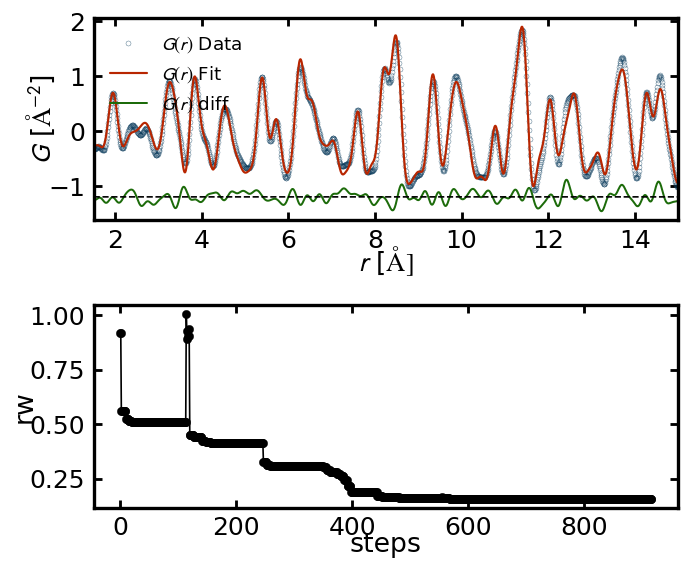

In [64]:
#First refinement
#GLAZERSYSTEMS = np.linspace(1, 14, 14)
LAT_A_I =  3.90
A_Y_DISP1_I = 0.01
A_Z_DISP1_I = 0.005
A_Y_DISP2_I = 0.005
A_Z_DISP2_I = 0.01
SCALE_I = 0.2
DELTA2_I = 1.4
UISO_A_I = 0.001
UISO_B_I = 0.000001
UISO_X_I = 0.001

GLAZERSYSTEMS = [10]
for GLAZERSYSTEM in GLAZERSYSTEMS:
    FIT_ID = "GLAZERSYSTEM_{}_fullstructure_fourAvar".format(GLAZERSYSTEM)
    modes = list(mode_values[GLAZERSYSTEM].values())
    initial_glazer_values = np.array(modes)*1 #not necessary, but can be changed
    if __name__ == "__main__":
        res[GLAZERSYSTEM], resfithook, recipe = main()

In [28]:
recipe.show()

Parameters
------------------------------------------------------------------------------
s1          0.2189639585937699
Delta2      0.0622713833841974
Aydisp1     0.00430686377329983
Azdisp1     0.022206423144975104
a_var       3.894262034258554
alpha_var   5.9360558945997655
beta_var    -9.510963364648891
Uiso_Ca     0.0042349004725438085
Uiso_Ti     0.0017747258948408143
Uiso_O      0.008090786761657729

crystal.s1  0.2189639585937699
crystal.r   [ 1.5   1.51  1.52 ... 14.98 14.99 15.  ]
crystal.y   [-0.321744 -0.323799 -0.323494 ... -1.00937  -1.01242  -1.00915 ]
crystal.dy  [1. 1. 1. ... 1. 1. 1.]

crystal.G1.delta1   0.0
crystal.G1.delta2   0.0622713833841974
crystal.G1.qbroad   0.07
crystal.G1.scale    1.0
crystal.G1.qdamp    0.06

crystal.G1.phase.lattice.a      7.580796029371541
crystal.G1.phase.lattice.b      7.646353328651879
crystal.G1.phase.lattice.c      7.646353328651879
crystal.G1.phase.lattice.alpha  90.0
crystal.G1.phase.lattice.beta   90.0
crystal.G1.phase.lattice.ga

In [65]:
def main():
    """
    This will run by default when the file is executed using
    "python file.py" in the command line

    Parameters
    ----------
    GLAZERSYSTEM, active glazer variables

    Returns
    ----------
    Fit residual
    """
    
    # Make some folders to store our output files.
    resdir = "res"
    fitdir = "fit"
    figdir = "fig"

    folders = [resdir, fitdir, figdir]

    # Loop over all folders
    for folder in folders:

        # If the folder does not exist...
        if not os.path.exists(folder):

            # ...then we create it.
            os.makedirs(folder)


    # Let the user know what fit we are running by printing to terminal.
    basename = FIT_ID
    print(basename)

    # Establish the full location of the data.
    data = os.path.join(DPATH, GR_NAME)

    # Establish the location of the cif file with the structure of interest
    # and load it into a diffpy structure object.
    strudir = os.path.abspath(MPATH)
    stru1 = Structure(filename=os.path.join(strudir, CIF_NAME))

    # Initialize the Fit Recipe by giving it this diffpy structure
    # as well as the path to the data file.
    recipe = makerecipe(stru1, data)
    all_variables = recipe.getNames()
    
    A_variables = []
    for v in all_variables:
        #if v.split("_")[0] in ['x', 'y', 'z']:
        if v in ['Aydisp', 'Azdisp']:
            A_variables.append(v)
    print('A cation variables to refine {}'.format(A_variables))
    
    glazer_variables = []
    for v in all_variables:
        if v in ['alpha_var', 'beta_var', 'gamma_var']:
            glazer_variables.append(v)
    print('Glazer variables to refine {}'.format(glazer_variables))
    

    # Tell the Fit Recipe we want to write the maximum amount of
    # information to the terminal during fitting.
    recipe.fithooks[0].verbose = 3

    # During the optimization, we fix and free parameters sequentially
    # as you would in PDFgui. This leads to more stability in the refinement.
    # We first fix all variables. "all" is a tag which incorporates
    # every parameter.
    
    # We then run a fit using the SciPy function "least_squares" which
    # takes as its arguments the function to be optimized, here recipe.residual,
    # as well as initial values for the fitted parameters, provided by
    # recipe.values. The x_scale="jac" argument is an optional argument
    # that provides for a bit more stability in the refinement.
    # "least_squares" is a bit more robust than "leastsq,"
    # which is another optimization function provided by SciPy.
    # "least_squares" supports bounds on refined parameters,
    #  while "leastsq" does not.
    #least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    #active_variables_exp = [i+'_var' for i in active_variables]

    print('Starting refinement...')
    recipe.fix("all")
    recipe.free("scale")
    #least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("a_var")
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.fix("a_var")
    for i in range(len(A_variables)):
        recipe.fix(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.fix(glazer_variables[i])
    recipe.fix("scale")
    
    # We free the thermal parameters and then run the fit.
    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    recipe.fix("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    
    # We free correlated motion parameter and run the fit.
    recipe.free("d2")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    recipe.fix("d2")
    
    # We free everything now and run the fit one last time.
    recipe.fix("all")

    recipe.free("scale")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("a_var")
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("d2")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    # We use the savetxt method of the profile to write a text file
    # containing the measured and fitted PDF to disk.
    # The file is named based on the basename we created earlier, and
    # written to the fitdir directory.
    profile = recipe.crystal.profile
    profile.savetxt(os.path.join(fitdir, basename + ".fit"))

    # We use the FitResults function to parse out the results from
    # the optimized Fit Recipe.
    res = FitResults(recipe)

    # We print these results to the terminal.
    res.printResults()

    # We use the saveResults method of FitResults to write a text file
    # containing the fitted parameters and fit quality indices to disk.
    # The file is named based on the basename we created earlier, and
    # written to the resdir directory.
    header = "crystal_HF.\n"
    res.saveResults(os.path.join(resdir, basename + ".res"), header=header)

    # We use the plotresults function we created earlier to make a plot of
    # the measured, calculated, and difference curves. We show this
    # as an interactive window and then write a pdf file to disk.
    # The file is named based on the basename we created earlier, and
    # written to the figdir directory.
    plotresults(recipe, os.path.join(figdir, basename))
    # plt.ion()

    return res

GLAZERSYSTEM_10
Constraining A cation positions with spacegroup P1
Start values for angles (deg) of Glazer system 10 are 8, -10, -10.
Creating variables for octahedron [0.  0.5 0. ]
Creating variables for octahedron [0. 0. 0.]
Creating variables for octahedron [0.  0.  0.5]
Creating variables for octahedron [0.  0.5 0. ]


/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


Creating variables for octahedron [0.  0.5 0.5]
Creating variables for octahedron [0.5 0.  0. ]
Creating variables for octahedron [0.5 0.  0.5]
Creating variables for octahedron [0.5 0.5 0. ]
Creating variables for octahedron [0.5 0.5 0.5]
A cation variables to refine ['Aydisp', 'Azdisp']
Glazer variables to refine ['alpha_var', 'beta_var']
Starting refinement...
1
Residual: 32070.7574046354
Variables
  Aydisp = 0.030000
  Azdisp = 0.030000
  a_var = 4.000000
  alpha_var = 8.000000
  beta_var = -10.000000
  s1 = 0.900000
2
Residual: 32070.757808328395
Variables
  Aydisp = 0.030000
  Azdisp = 0.030000
  a_var = 4.000000
  alpha_var = 8.000000
  beta_var = -10.000000
  s1 = 0.900000
3
Residual: 32070.762529088788
Variables
  Aydisp = 0.030000
  Azdisp = 0.030000
  a_var = 4.000000
  alpha_var = 8.000000
  beta_var = -10.000000
  s1 = 0.900000
4
Residual: 32070.761713406944
Variables
  Aydisp = 0.030000
  Azdisp = 0.030000
  a_var = 4.000000
  alpha_var = 8.000000
  beta_var = -10.000000


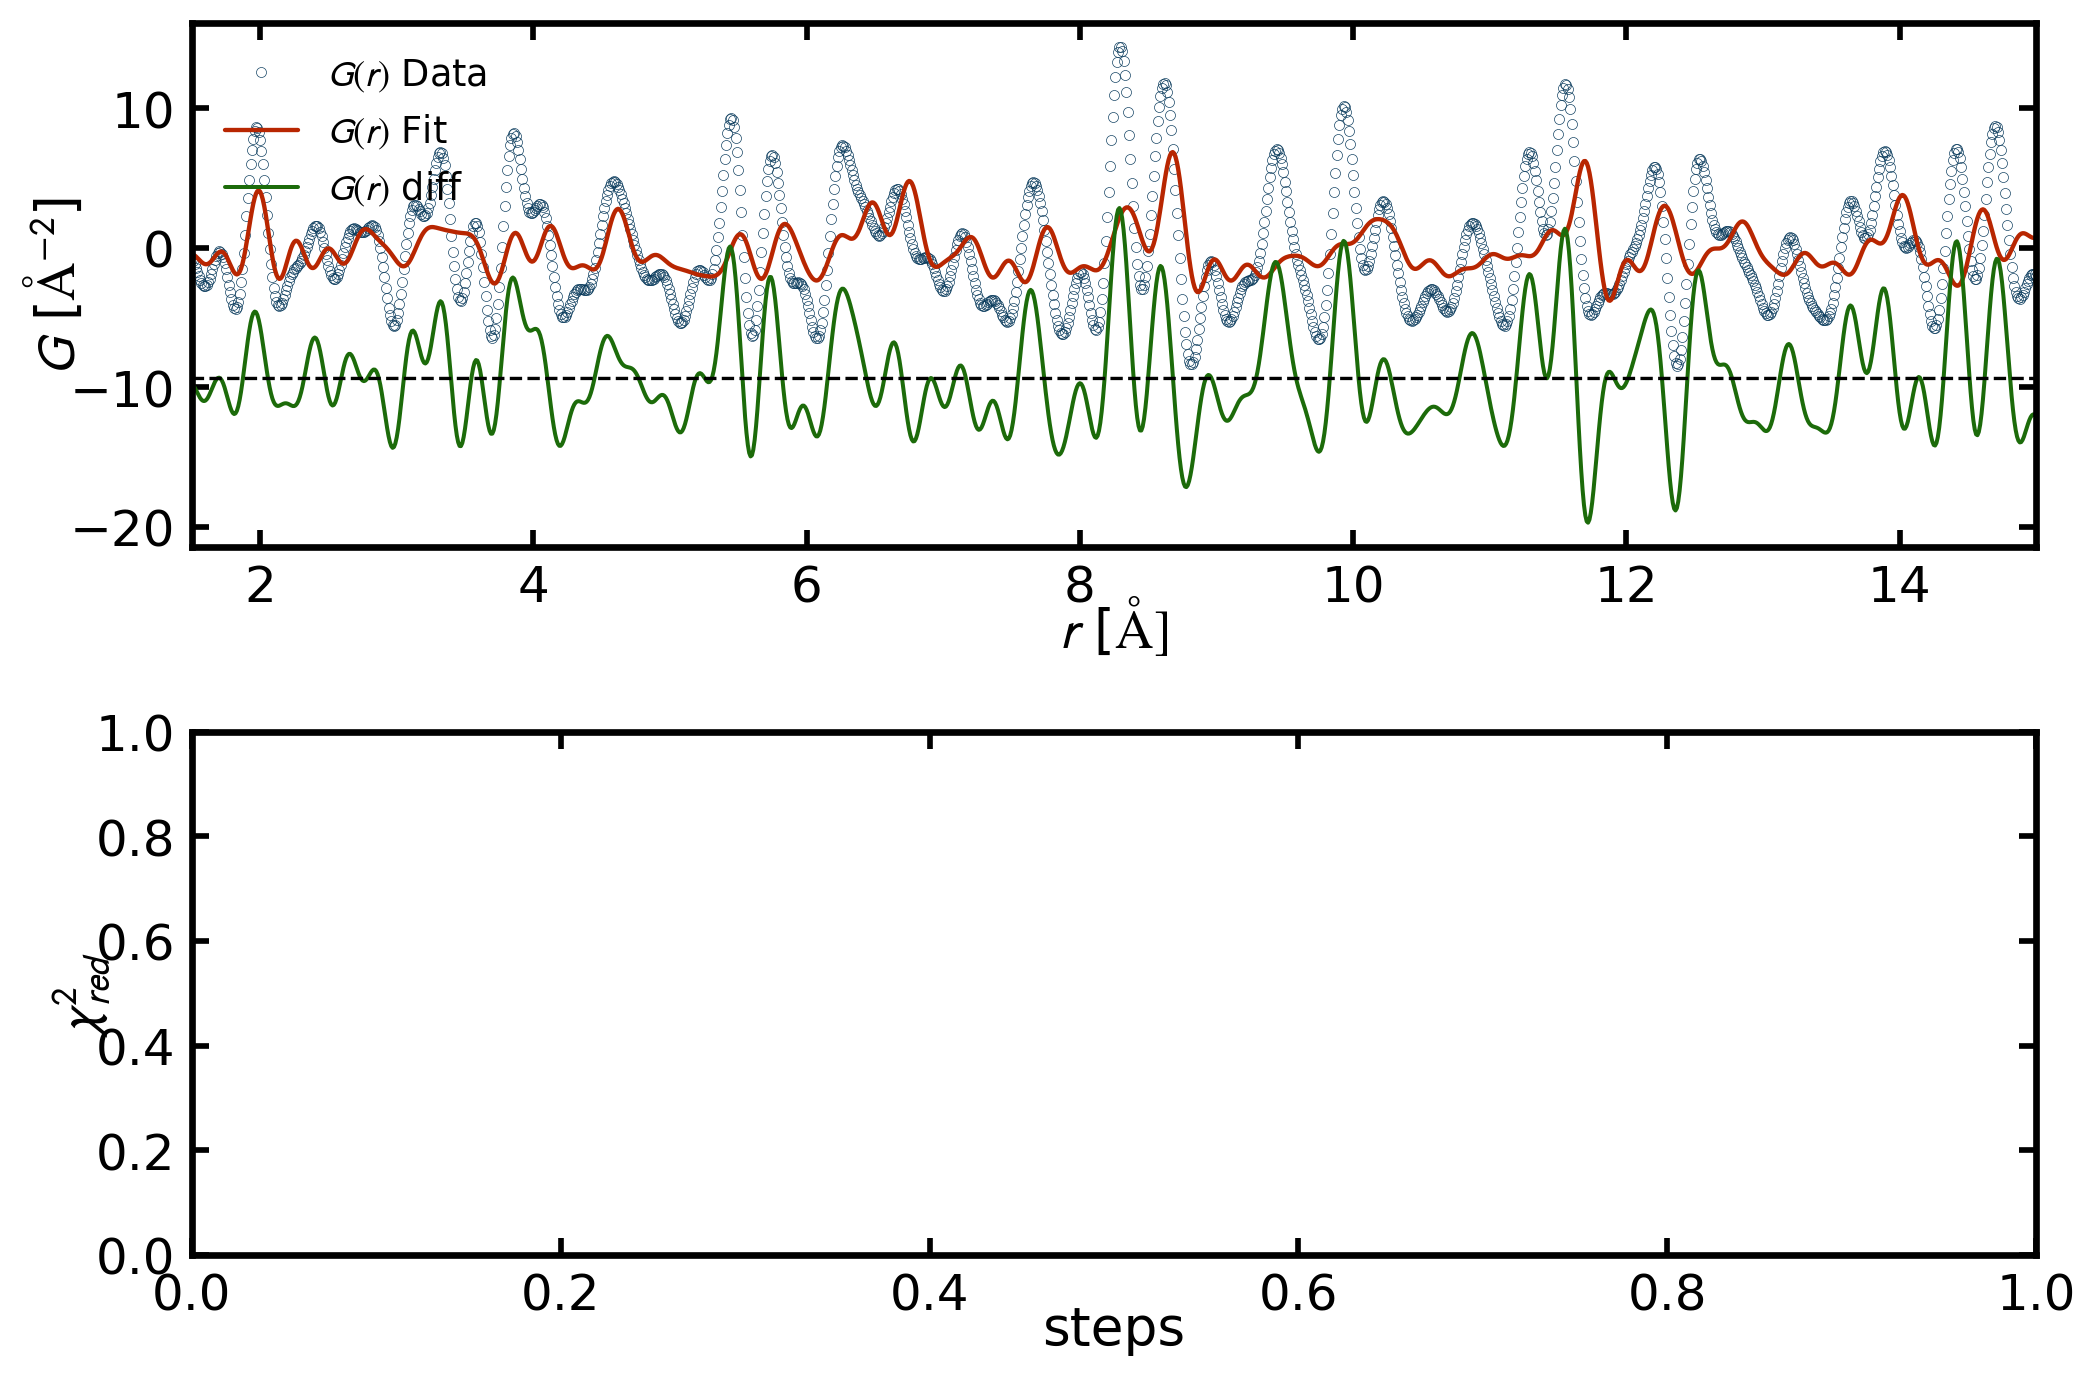

Process ForkPoolWorker-88:
Process ForkPoolWorker-89:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/sandras/anaconda3/envs/diffpy_new/lib/python3.

In [66]:
#Second refinement
GLAZERSYSTEMS = [10]
for GLAZERSYSTEM in GLAZERSYSTEMS:
    FIT_ID = "GLAZERSYSTEM_{}".format(GLAZERSYSTEM)
    modes = list(mode_values[GLAZERSYSTEM].values())
    initial_glazer_values = np.array(modes)*1 #not necessary, but can be changed
    A_Y_DISP_I = 0.03
    A_Z_DISP_I = 0.03
    SCALE_I = 0.9
    DELTA2_I = 1.4
    UISO_A_I = 0.001
    UISO_B_I = 0.000001
    UISO_X_I = 0.001

    if __name__ == "__main__":
        res[GLAZERSYSTEM] = main()

In [ ]:
# Only oxygens

GLAZERSYSTEM_4
Start values for angles (deg) of Glazer system 4 are 8, 13, -7.
Creating variables for octahedron [0.  0.5 0. ]
Creating variables for octahedron [0. 0. 0.]
Creating variables for octahedron [0.  0.  0.5]
Creating variables for octahedron [0.  0.5 0. ]
Creating variables for octahedron [0.  0.5 0.5]
Creating variables for octahedron [0.5 0.  0. ]
Creating variables for octahedron [0.5 0.  0.5]
Creating variables for octahedron [0.5 0.5 0. ]
Creating variables for octahedron [0.5 0.5 0.5]


/home/sandras/anaconda3/envs/diffpy_new/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


Glazer variables ['alpha_var', 'beta_var', 'gamma_var']
Starting refinement...
1
Residual: 3136.3905018501973
Variables
  s1 = 1.000000
2
Residual: 3136.39031500405
Variables
  s1 = 1.000000
3
Residual: 1825.5985912764322
Variables
  s1 = 1.209074
4
Residual: 1825.5985912764422
Variables
  s1 = 1.209074
5
Residual: 1825.5985912764324
Variables
  s1 = 1.209074
6
Residual: 1825.5985912764324
Variables
  a_var = 4.000000
  alpha_var = 8.000000
  beta_var = 13.000000
  gamma_var = -7.000000
  s1 = 1.209074
7
Residual: 1825.5985912764422
Variables
  a_var = 4.000000
  alpha_var = 8.000000
  beta_var = 13.000000
  gamma_var = -7.000000
  s1 = 1.209074
8
Residual: 1825.6011582603887
Variables
  a_var = 4.000000
  alpha_var = 8.000000
  beta_var = 13.000000
  gamma_var = -7.000000
  s1 = 1.209074
9
Residual: 1825.5985093699378
Variables
  a_var = 4.000000
  alpha_var = 8.000000
  beta_var = 13.000000
  gamma_var = -7.000000
  s1 = 1.209074
10
Residual: 1825.5987522219089
Variables
  a_var = 4.

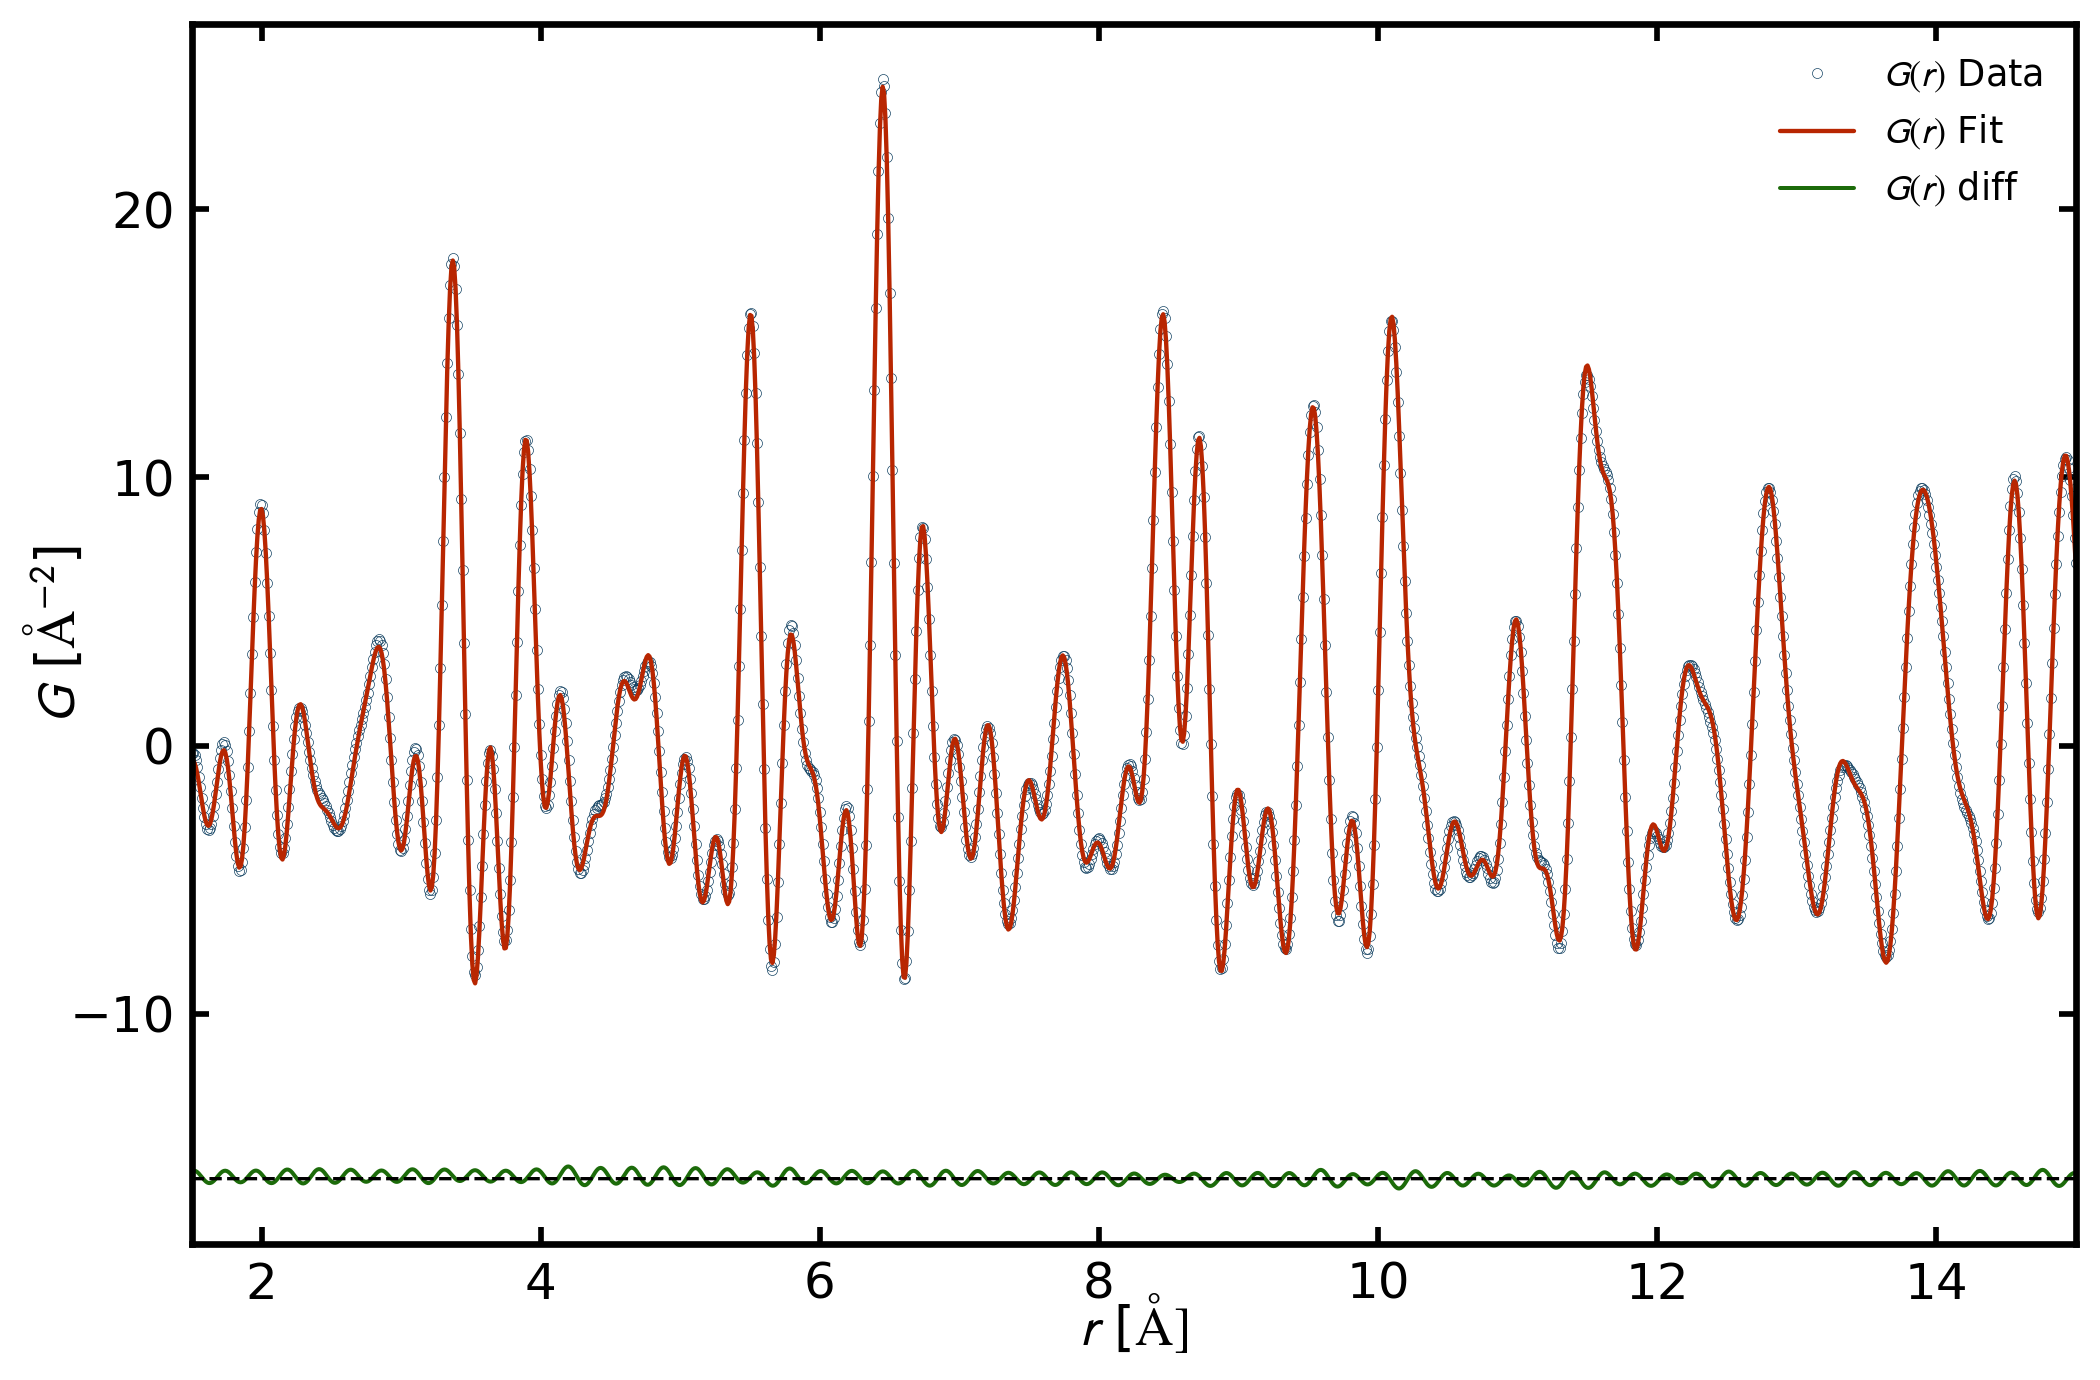

In [153]:
GLAZERSYSTEMS = [4]
for GLAZERSYSTEM in GLAZERSYSTEMS:
    FIT_ID = "GLAZERSYSTEM_{}".format(GLAZERSYSTEM)
    modes = list(mode_values[GLAZERSYSTEM].values())
    initial_values = np.array(modes)*0.6
    initial_values = [8,13,-7]
    
    if __name__ == "__main__":
        res[GLAZERSYSTEM] = main(GLAZERSYSTEM, initial_values)

Text(0, 0.5, 'mode values')

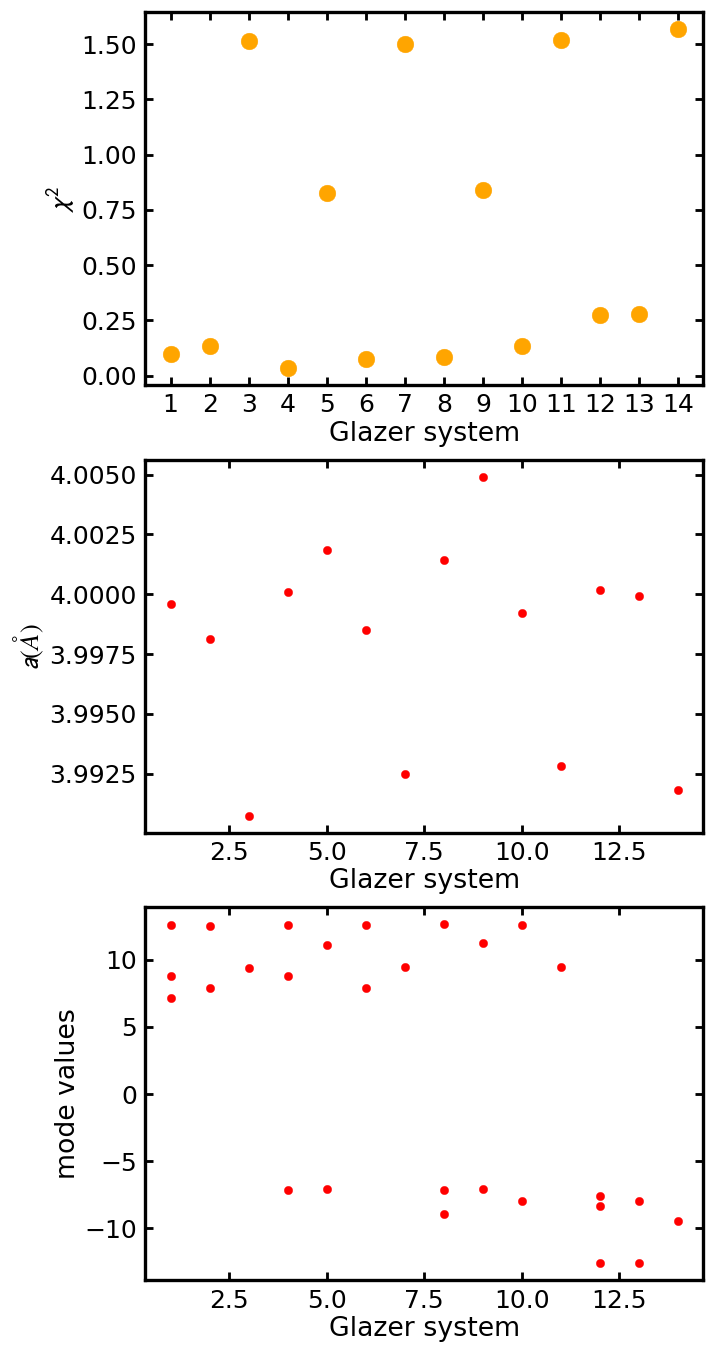

In [180]:
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
labels = [r'#1: $\alpha^+$, $\beta^+$, $\gamma^+$', r'#2: $\alpha^+$, $\beta^+$, $\beta^+$', 
          r'#3: $\alpha^+$, $\alpha^+$, $\alpha^+$', r'#4: $\alpha^+$, $\beta^+$, $\gamma^-$', 
          r'#5: $\alpha^+$, $\alpha^+$, $\gamma^-$', r'#6: $\alpha^+$, $\beta^+$, $\beta^-$', 
          r'#7: $\alpha^+$, $\alpha^+$, $\alpha^-$', r'#8: $\alpha^+$, $\beta^-$, $\gamma^-$', 
          r'#9: $\alpha^+$, $\alpha^-$, $\gamma^-$', r'#10: $\alpha^+$, $\beta^-$, $\beta^-$', 
          r'#11: $\alpha^+$, $\alpha^-$, $\alpha^-$', r'#12: $\alpha^-$, $\beta^-$, $\gamma^-$', 
          r'#13: $\alpha^-$, $\beta^-$, $\beta^-$', r'#14: $\alpha^-$, $\alpha^-$, $\alpha^-$']
GLAZERSYSTEMS = np.linspace(1, 14, 14)
fig,ax = plt.subplots(3,1, figsize=(6,14), dpi=120)

for GLAZERSYSTEM in GLAZERSYSTEMS:
    ax[0].plot(int(GLAZERSYSTEM), res[GLAZERSYSTEM].rchi2, marker='o', ms=10, color='orange')
ax[0].set_xlabel('Glazer system', labelpad=2)
ax[0].set_ylabel(r'$\chi^2$', labelpad=2)
ax[0].set_xticks(range(1, 15))
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for GLAZERSYSTEM in GLAZERSYSTEMS:
    i = list(GLAZERSYSTEMS).index(GLAZERSYSTEM)
    for v in res[GLAZERSYSTEM].varnames:
        if v in ['a_var']:
            j = list(res[GLAZERSYSTEM].varnames).index(v)
            ax[1].plot(int(GLAZERSYSTEM), res[GLAZERSYSTEM].varvals[j], marker='o', color='red', label = labels[i])
    
    #ax[1].text(i, 0.9, labels[i])
ax[1].set_xlabel('Glazer system', labelpad=2)
ax[1].set_ylabel(r'$a (\AA)$', labelpad=2)

#ax[1].legend(loc=0)
l = ['alpha_var', 'beta_var', 'gamma_var']
for GLAZERSYSTEM in GLAZERSYSTEMS:
    for v in res[GLAZERSYSTEM].varnames:
        if v in l:
            j = list(res[GLAZERSYSTEM].varnames).index(v)

            ax[2].plot(int(GLAZERSYSTEM), res[GLAZERSYSTEM].varvals[j], marker='o', color='red')#, label = l[i])
ax[2].set_xlabel('Glazer system', labelpad=2)
ax[2].set_ylabel('mode values', labelpad=2)

